<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-ансамблей---случайный-лес" data-toc-modified-id="Модель-ансамблей---случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель ансамблей - случайный лес</a></span></li><li><span><a href="#Модель-градиентного-бустинга---CatBoost" data-toc-modified-id="Модель-градиентного-бустинга---CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель градиентного бустинга - CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии:" data-toc-modified-id="Модель-линейной-регрессии:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии:</a></span></li><li><span><a href="#Модель-ансамблей---Случайный-лес:" data-toc-modified-id="Модель-ансамблей---Случайный-лес:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель ансамблей - Случайный лес:</a></span></li><li><span><a href="#Модель-градиентного-бустинга---CatBoost" data-toc-modified-id="Модель-градиентного-бустинга---CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель градиентного бустинга - CatBoost</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as cb

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

In [4]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

In [6]:
df.shape

(26496, 1)

In [7]:
#Проверим в хронологичном ли порядке расположены даты и посмотрим информацию о данных:
display(df.index.is_monotonic)
display(df.head(10))
df.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


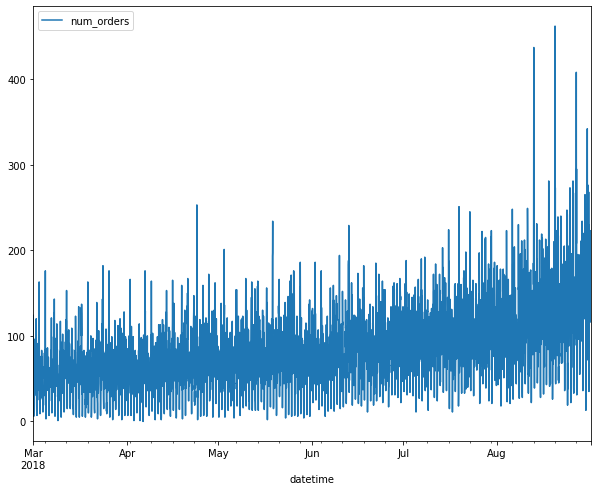

In [8]:
#Сделаем ресемплирование с сумой заказов на каждый час по часам и посмотрим график:
df = df.resample('1H').sum() 
df.plot(figsize=(10,8));

In [9]:
#Найдем сначала лимиты и концы:
print('Starting date:',df.index.min())
print('Ending date:',df.index.max())
print('Total time:',df.index.max() - df.index.min())
print()
df.describe()

Starting date: 2018-03-01 00:00:00
Ending date: 2018-08-31 23:00:00
Total time: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


*Данные собраны за 183 дня и 23 часа. Минимальное количество заказов за 1 час: 0, а максимальное: 462.*

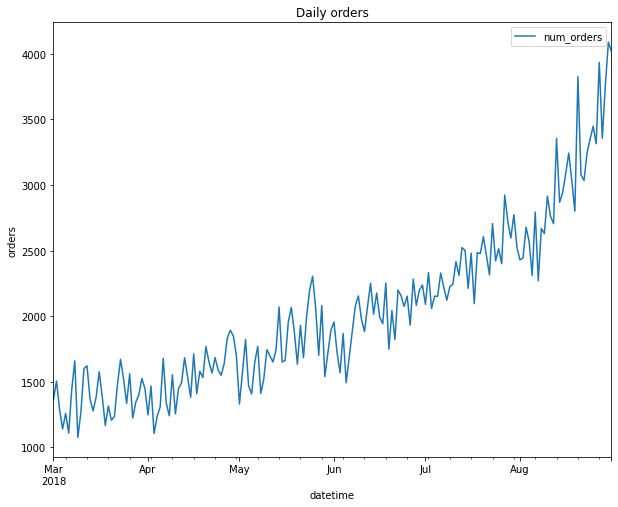

In [16]:
#Посмотрим на график вызовов по дням:
df.resample('1D').sum().plot(title='Daily orders', figsize=(10,8),ylabel='orders');

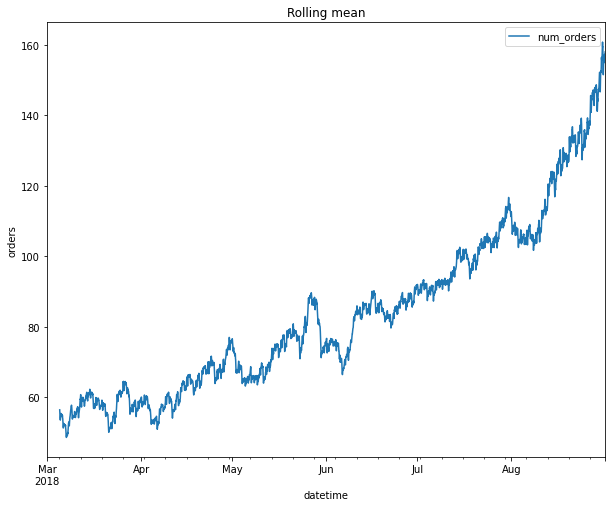

In [17]:
#Посмотрим на скользящую среднюю 100-ю:
df.rolling(100).mean().plot(figsize=(10,8),title='Rolling mean',ylabel='orders');

*Данные имеют большие колебания, но с помощью средней скользящей мы уже видим восхдящий тренд вверх.*

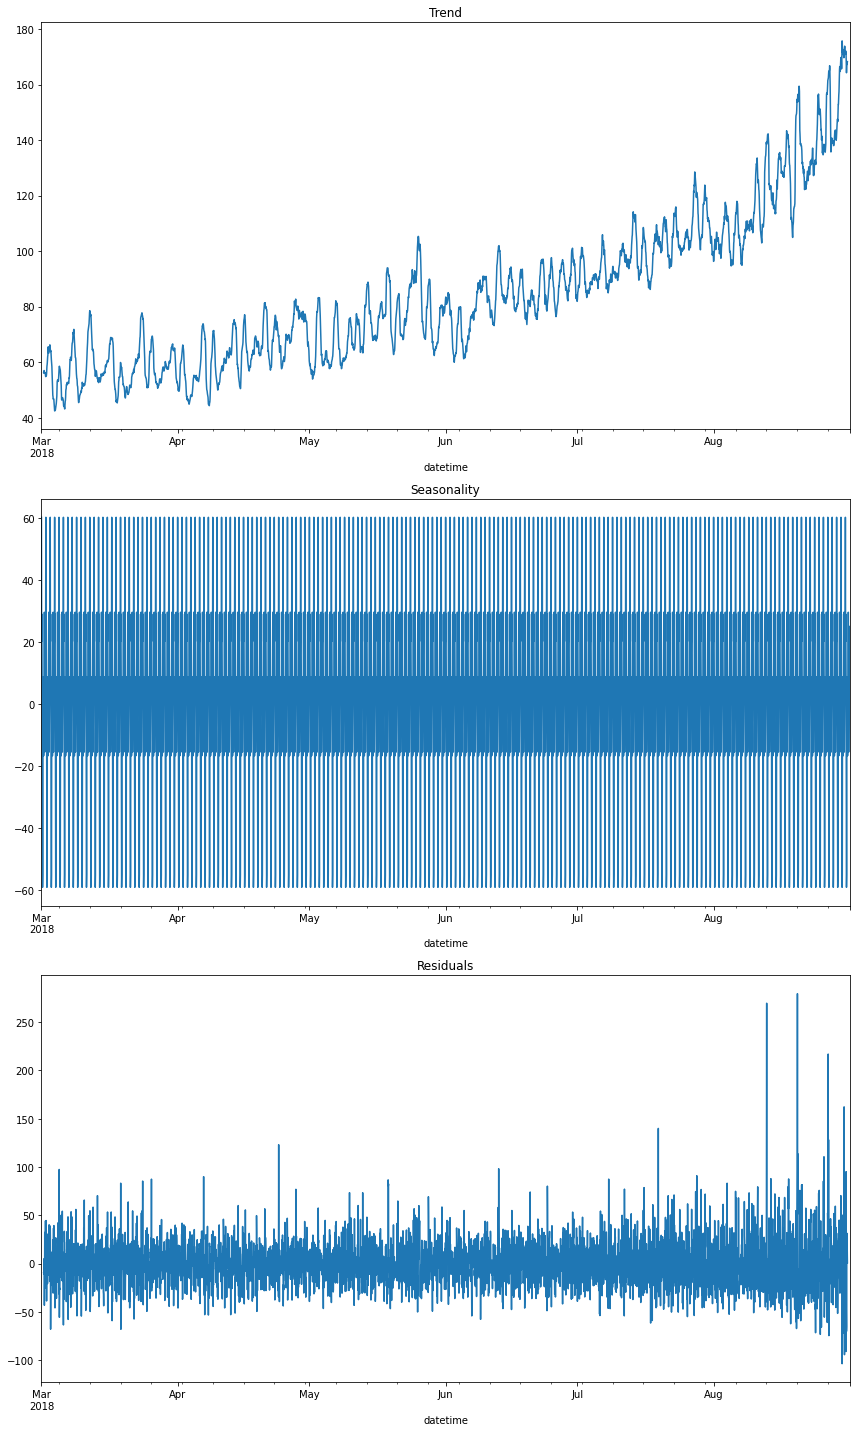

In [10]:
#Теперь проведем анализ временных рядов:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

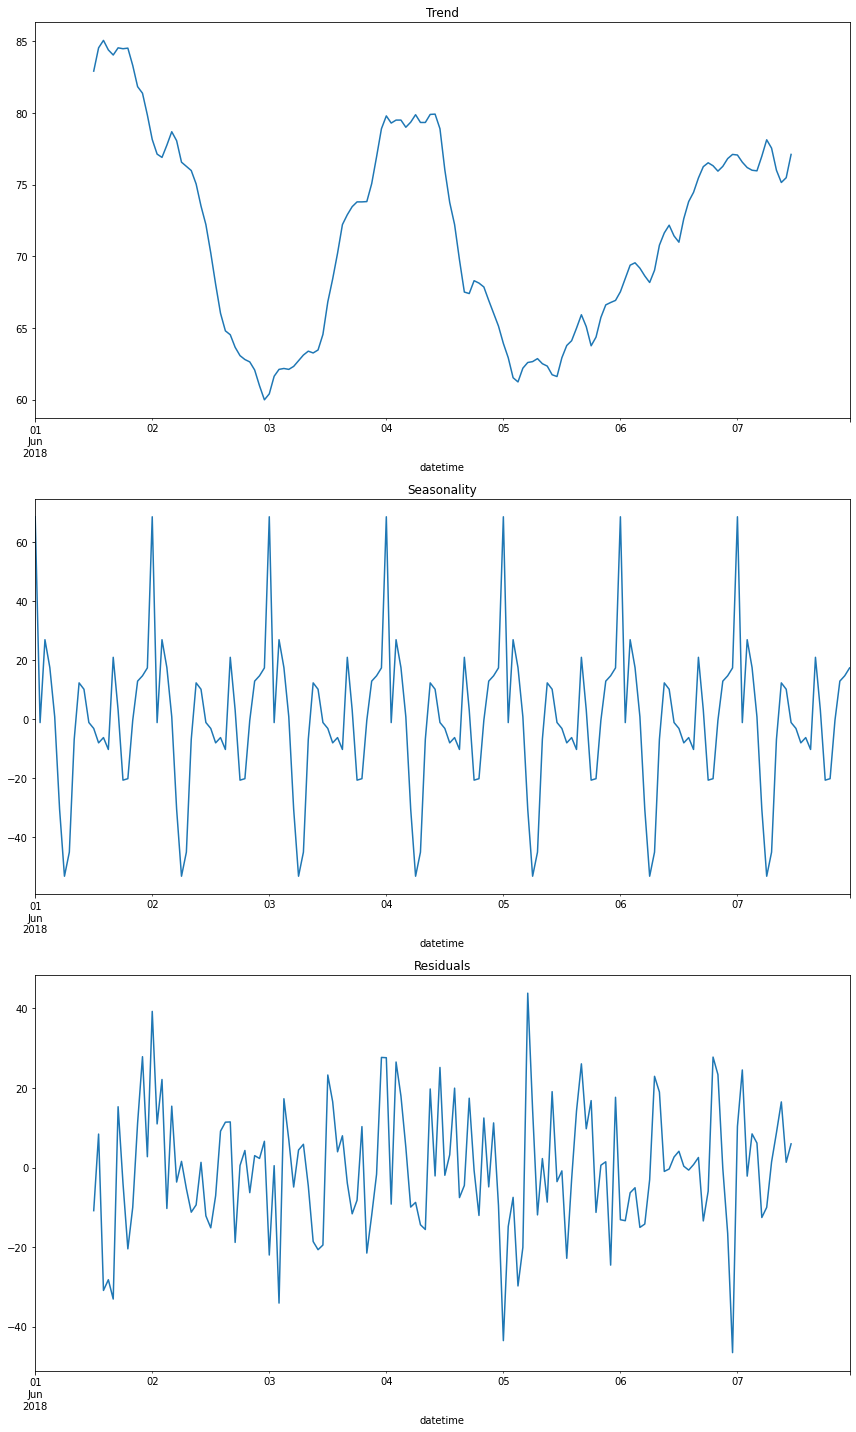

In [11]:
#Графики показывают высокую частотность и суточную сезонность, уменьшим интервал и посмотрим за неделю:
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


*Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.*

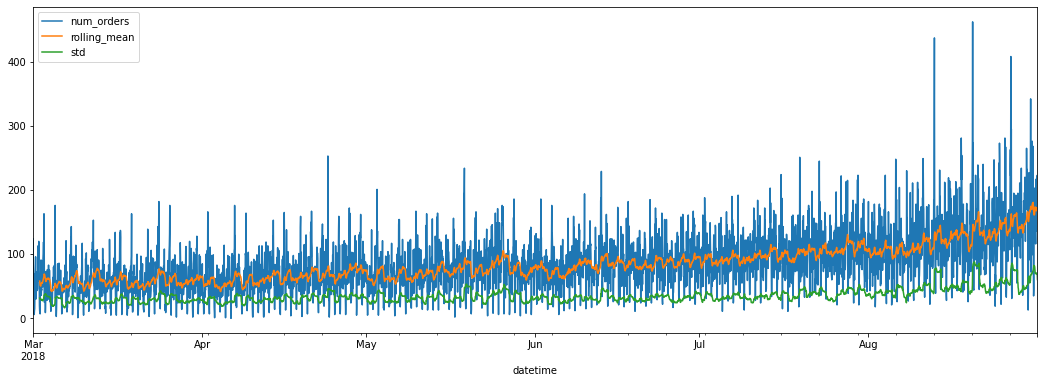

In [12]:
df_plot = df.copy()
df_plot['rolling_mean'] = df_plot.rolling(30).mean()
df_plot['std'] = df_plot['num_orders'].rolling(30).std()
df_plot.plot(figsize=(18, 6));

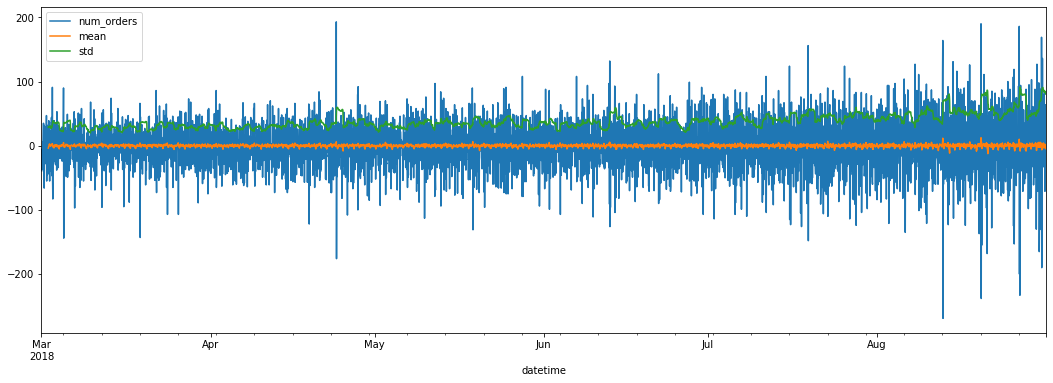

In [13]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(30).mean()
df_shift['std'] = df_shift['num_orders'].rolling(30).std()
df_shift.plot(figsize=(18, 6));

**Вывод:**<br>
Провели анализ данных. Методом декомпозиции были выделены следующие аспекты:
- За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.
- На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

## Обучение

*Обучим три модели ориентируясь на метрику RMSE. В качестве моделей используем `Линейную регрессию`, `Случайный лес` и `CatBoostRegressor`.*

In [14]:
#Пропишем функцию для создания признаков, а именно день недели, час -"отстающие значения", скользящее среднее:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [15]:
#Применим функцию с лагом до 24 часов и 100-м скользящим средним:
make_features(df, 24, 100)

In [16]:
#Удалим пропyски и посмотрим данные:
df = df.dropna()
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [17]:
#Поделим данные на обучающ. и тестовую выборки, к ним подберем признаки и целевой:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [18]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 27)
(432, 27)
(3884,)
(432,)


In [19]:
#Пропишем функцию для расчета метрики RMSE:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создадим метрику RMSE:
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Модель линейной регрессии

*В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию `TimeSeriesSplit()`.*

In [20]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Модель
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
#Обучаем модель
regression.fit(features_train, target_train)
#Определяем RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 28.412402437142486
CPU times: user 275 ms, sys: 365 ms, total: 640 ms
Wall time: 592 ms


### Модель ансамблей - случайный лес

In [21]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Модель
forest = RandomForestRegressor()
#Определяем словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяем GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 4min 14s, sys: 739 ms, total: 4min 15s
Wall time: 4min 16s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe69ad0f0b0>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

*Определим оптимальные гиперпараметры и качество модели на кросс-валидации:*

In [22]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(forest_score)
print('_______________')

{'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 25}
11.892706514114593
_______________
CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 23.6 ms


### Модель градиентного бустинга - CatBoost

In [23]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Модель
cbr = cb.CatBoostRegressor()
#Определяем словарь с набором параметров
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#Применяем GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cbr, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8427470	total: 48.8ms	remaining: 48.8s
100:	learn: 17.8692599	total: 205ms	remaining: 1.83s
200:	learn: 15.9607824	total: 355ms	remaining: 1.41s
300:	learn: 14.7128169	total: 506ms	remaining: 1.17s
400:	learn: 13.5776480	total: 654ms	remaining: 977ms
500:	learn: 12.6540101	total: 802ms	remaining: 799ms
600:	learn: 11.7146676	total: 956ms	remaining: 635ms
700:	learn: 10.9266052	total: 1.11s	remaining: 473ms
800:	learn: 10.2835647	total: 1.25s	remaining: 311ms
900:	learn: 9.6413875	total: 1.4s	remaining: 154ms
999:	learn: 9.0798153	total: 1.55s	remaining: 0us
0:	learn: 31.8817805	total: 3.32ms	remaining: 3.32s
100:	learn: 20.1994746	total: 219ms	remaining: 1.95s
200:	learn: 18.5270027	total: 474ms	remaining: 1.88s
300:	learn: 17.4868682	total: 666ms	remaining: 1.55s
400:	learn: 16.5724681	total: 852ms	remaining: 1.27s
500:	learn: 15.8557860	total: 1.04s	remaining: 1.03s
600:	learn: 15.2104647	total: 1.22s	remaining: 813ms
700:	learn: 14.6605748	total: 1.41s	remaining: 602ms


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe69b062cf0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe69b50a040>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

*Определим оптимальные гиперпараметры и качество модели на кросс-валидации:*

In [24]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)
print(cb_score)
print('_______________')

{'depth': 4, 'learning_rate': 0.03}
17.416309815339226
_______________
CPU times: user 12.6 ms, sys: 4 µs, total: 12.6 ms
Wall time: 11.4 ms


**Вывод:** <br>
Мы обучили 3 модели и подобрали гиперпараметры методом грид серч, зафиксировав лучшие гиперпараметры, показатели по времени обучения и метрике RMSE. Лучшие показатели у модели - `Случайный лес`

## Тестирование

In [25]:
#Тест на адекватность модели:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 59.157


### Модель линейной регрессии:

In [26]:
%%time
#Обучаем модель
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

#Определяем метрику RMSE
regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)
print('RMSE модели Линейной регрессии:', regression_RMSE)

RMSE модели Линейной регрессии: 45.174
CPU times: user 32.3 ms, sys: 8.1 ms, total: 40.4 ms
Wall time: 10.7 ms


In [27]:
#Пропишем функцию для построения сравнительных графиков "целевой признак - предсказание модели":
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6))

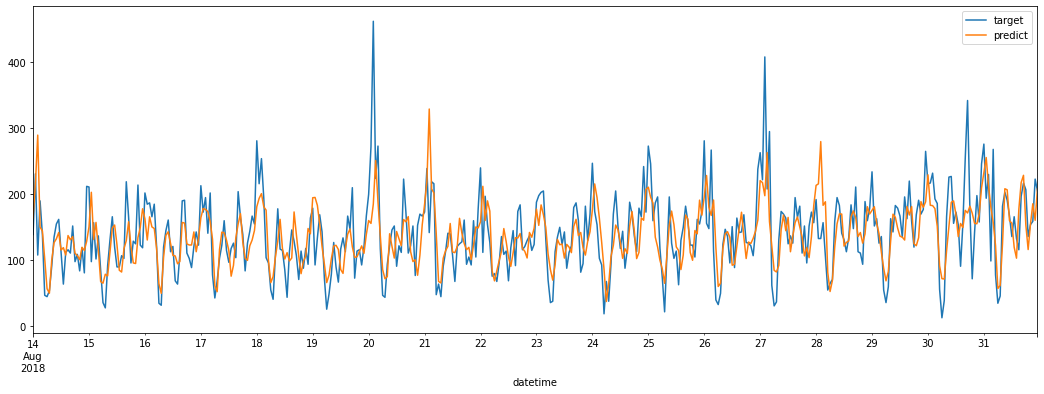

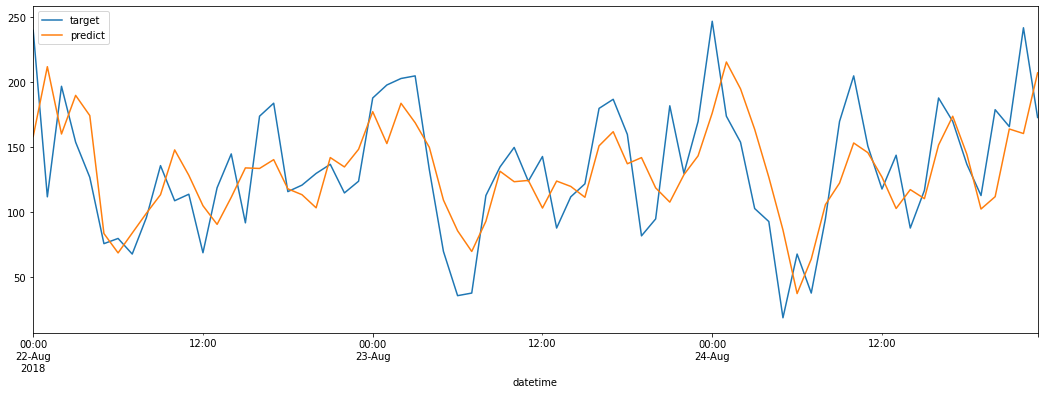

In [28]:
#Сравним наши данные и что мы предсказали по графику:
graphicaizer(regression_model_predictions)

### Модель ансамблей - Случайный лес:

In [29]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику RMSE
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 43.701
CPU times: user 1.07 s, sys: 7.97 ms, total: 1.08 s
Wall time: 1.09 s


In [30]:
#Объявлявим функцию для построения графика важности признаков, она показываеи только те признаки,важность которых больше 0.0:
def feature_importance_hist(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i>0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="g")
    plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

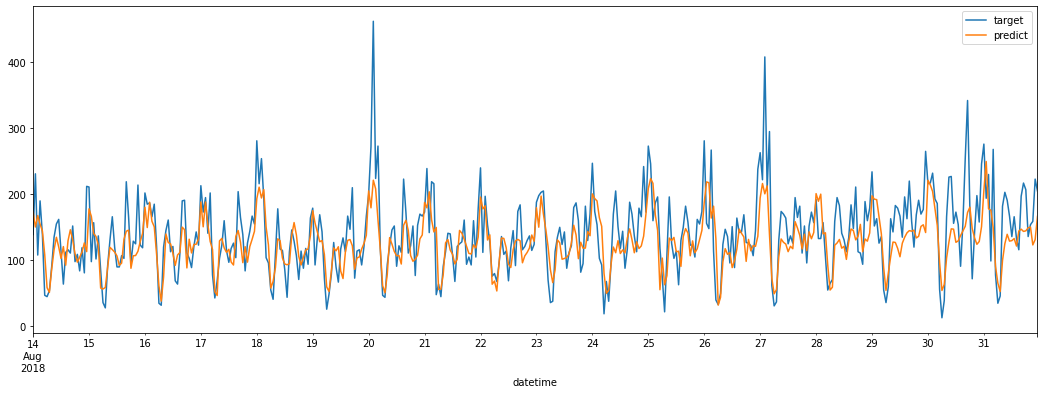

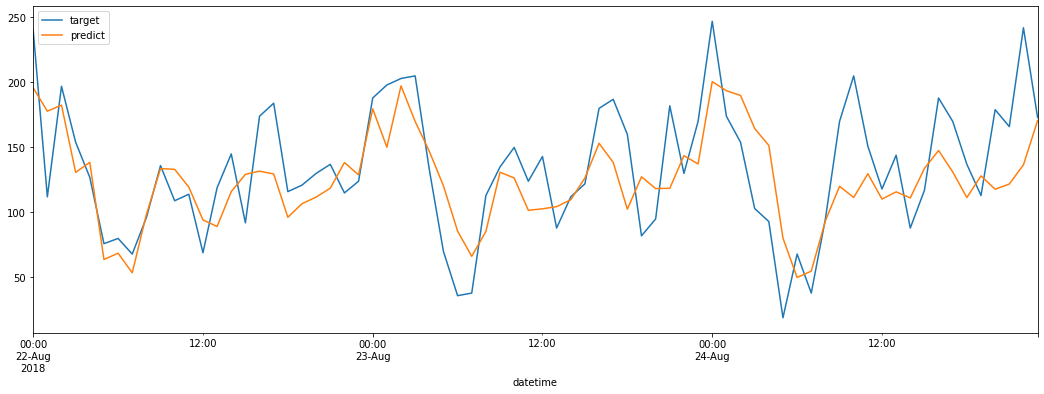

In [31]:
#Сравниваю наши данные и что мы предсказали по графику:
graphicaizer(forest_model_predictions)

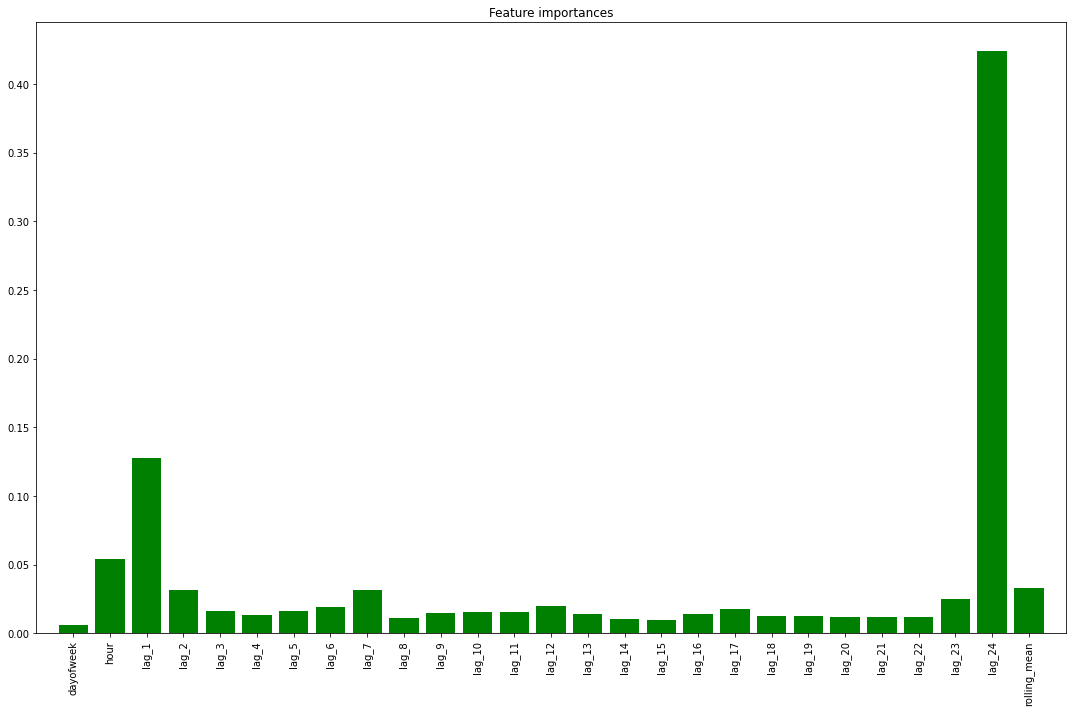

In [32]:
#Строим график важности признаков модели:
feature_importance_hist(forest_model, features_train)

### Модель градиентного бустинга - CatBoost

In [33]:
%%time

#Обучаем модель на оптимальных гиперпараметрах
cb_model = cb.CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)

#Определяем метрику RMSE
cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 38.2170015	total: 2.76ms	remaining: 2.76s
100:	learn: 24.2674485	total: 253ms	remaining: 2.25s
200:	learn: 22.7692978	total: 499ms	remaining: 1.99s
300:	learn: 21.7085475	total: 745ms	remaining: 1.73s
400:	learn: 20.7832879	total: 1.02s	remaining: 1.53s
500:	learn: 19.9726626	total: 1.28s	remaining: 1.28s
600:	learn: 19.3182983	total: 1.56s	remaining: 1.03s
700:	learn: 18.7501925	total: 1.81s	remaining: 774ms
800:	learn: 18.2674206	total: 2.07s	remaining: 514ms
900:	learn: 17.8233171	total: 2.35s	remaining: 258ms
999:	learn: 17.4163098	total: 2.63s	remaining: 0us
RMSE модели CatBoostRegressor: 40.665
CPU times: user 2.7 s, sys: 101 ms, total: 2.8 s
Wall time: 3.93 s


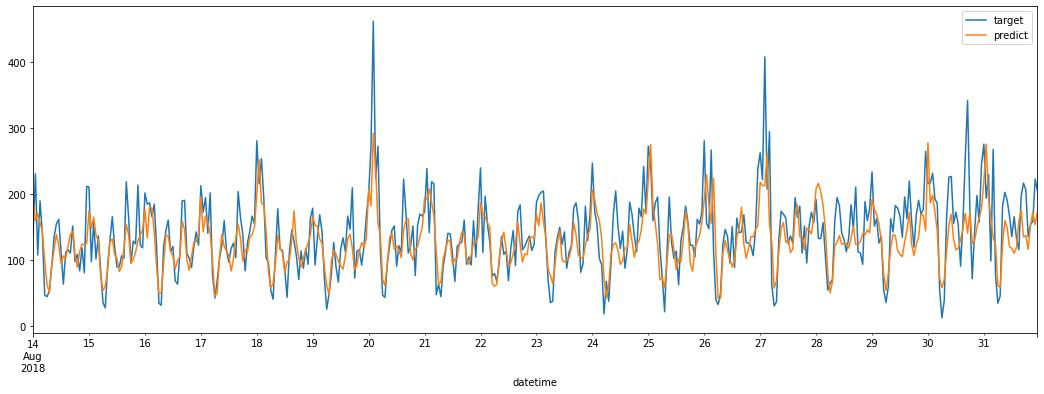

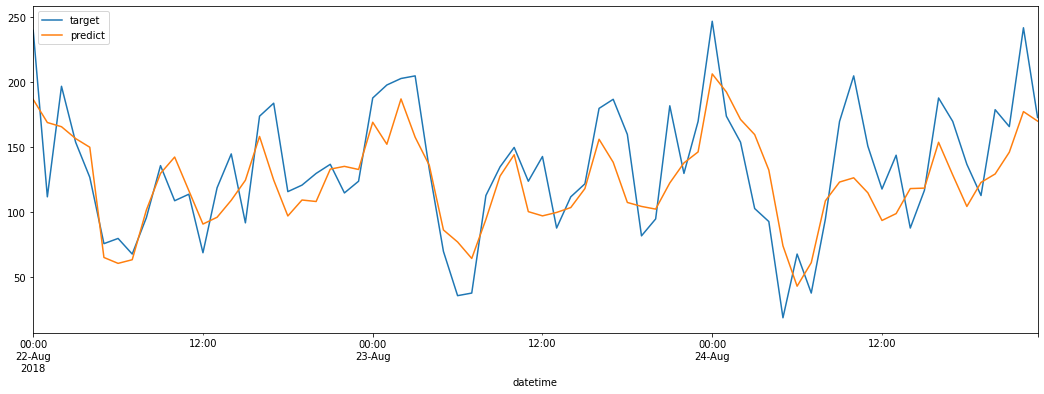

In [34]:
#Сравниваем наши данные и что мы предсказали по графику:
graphicaizer(cb_model_predictions)

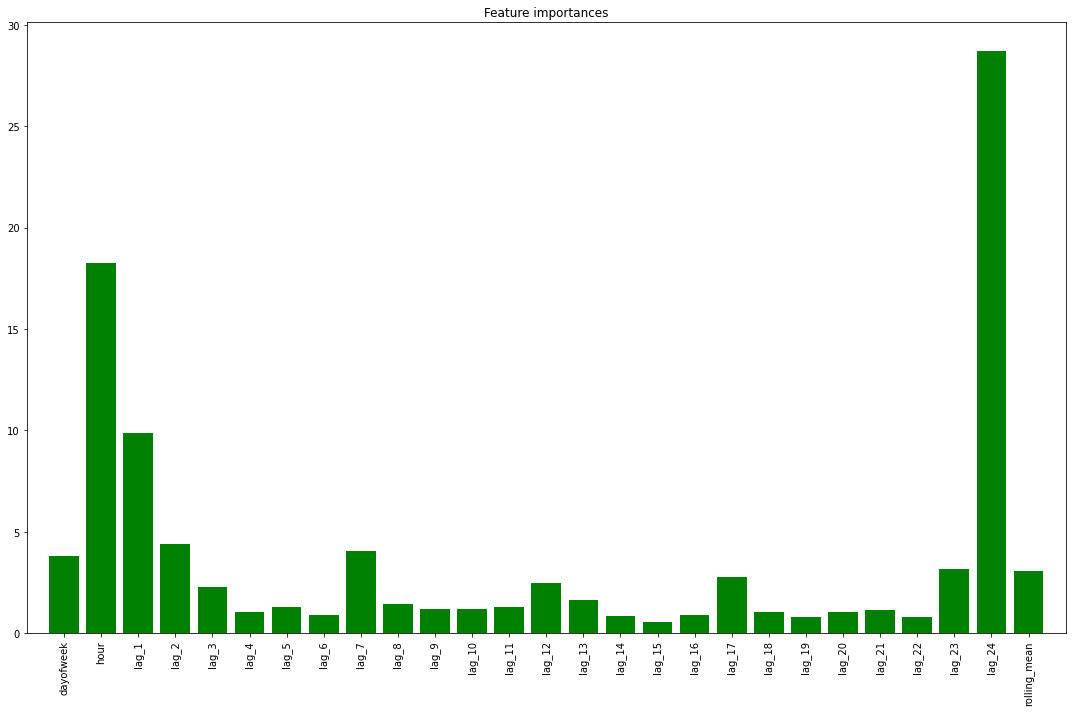

In [35]:
#Строим график важности признаков модели:
feature_importance_hist(cb_model, features_train)

In [36]:
#Cмотрим итоговые RMSE для каждой модели, наилучшей будет та ммодель у которой отклонение минимально:
print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))
print('RMSE модели Линейной регрессии:', regression_RMSE)
print('RMSE модели Случайного леса:', forest_RMSE)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

RMSE для проверки модели на адекватность: 59.157
RMSE модели Линейной регрессии: 45.174
RMSE модели Случайного леса: 43.701
RMSE модели CatBoostRegressor: 40.665


## Общий вывод

После загрузки данных и их анализа мы выявили, что:
- За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.
- На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

Затем мы добавили дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. На дополненном датасете подобраны оптимальные гиперпараметры для моделей.

На последнем этапе проведено тестирование всех моделей, каждой из них удалось достичь требуемого показателя метрики RMSE. Анализ сравнительных графиков в двух масштабах, показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах, но в целом, угадывают направления движения. Наилучший показатель RMSE в данном случае у CatBoostRegressor = 40,889.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Ахахахах Андрей! Ну ты прям гимн мне спел! )))) Я просто был рад помочь тебе и также был рад работать с тобой **совместно** над проектом!
</div>